<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/error_analysis_%E6%94%B9%E5%96%84%E5%BE%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install catboost
from google.colab import drive
drive.mount('/content/drive')
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import warnings;warnings.simplefilter('ignore')
from sklearn.model_selection import cross_validate
from sklearn.linear_model import BayesianRidge, LinearRegression,Lasso,Ridge
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.scorer import make_scorer
import plotly.express as px
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def mape(a, b):
    a ,b = np.array(a) ,np.array(b)
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

def rmse(y_t,y_p):
  return np.sqrt(mean_squared_error(y_t,y_p))

def metric(y_t,y_p,name):
  res = {'R2':np.clip(r2_score(y_t,y_p),0,1),
         'RMSE':rmse(y_t,y_p),
         'MAPE':mape(y_t,y_p)}
  return pd.DataFrame(res,index=[name])

def clean(df):
  condition = (df['N+A']>=36)
  return df.loc[condition]

def std_filter(df,num):
  for col in df.columns:
    ub = df[col].median() + num*df[col].std()
    lb = df[col].median() - num*df[col].std()
    df = df[(df[col] > lb)&(df[col] < ub)]
  df = df.dropna()
  return df

def get_result(y_test,y_pred):
  res = pd.DataFrame()
  for y_name in y_columns:
    row = metric(y_test[y_name],y_pred[y_name],y_name)
    res = res.append(row)
  res.loc['AVG'] = res.mean()
  return res

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# load

In [0]:
train_4521 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0)
test_170 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_170.csv',index_col=0)
test_250 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).drop(95)

# merge

In [4]:
full = train_4521.append(test_170).append(test_250)
full = full.reset_index(drop=True)
full.shape

(4940, 27)

# clean and drop duplicates

In [5]:
# select N+A>36
full = clean(full)
print(full.shape)

# use std filter
full = std_filter(full,3)
print(full.shape)

(2892, 27)
(2181, 27)


# define columns

In [0]:
cols = full.columns.tolist()
features = cols[:4]
y_columns = cols[4:]

# reset_index

In [7]:
full = full.reset_index(drop=True)
full.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,103.3,118.9,143.1,36.592,0.002,0.000,0.000,3.032,0.536,4.599,0.437,10.119,8.158,8.066,3.144,8.824,9.438,5.356,5.727,6.099,9.952,4.479,3.780,0.849,5.160,0.636,0.368
1,101.5,123.6,146.9,36.315,1.602,1.121,0.144,2.885,2.105,2.205,0.432,7.131,5.531,6.829,3.049,8.318,8.747,6.361,6.053,6.185,10.905,5.935,3.510,1.391,6.873,1.145,0.652
2,102.5,120.3,145.6,36.283,0.785,0.566,0.069,3.520,1.368,2.639,0.437,10.108,8.094,7.125,3.103,8.973,6.584,7.905,5.615,6.198,9.347,4.856,3.456,0.824,5.031,0.730,0.348
3,105.9,125.2,147.9,37.284,2.925,2.485,0.269,3.779,3.659,3.222,1.251,6.773,5.907,7.233,3.674,7.943,8.049,6.549,6.626,5.373,9.822,4.571,2.820,0.984,3.934,0.504,0.565
4,94.3,121.4,146.6,40.555,0.042,0.012,0.038,3.451,2.045,5.571,1.019,7.438,5.789,8.007,3.714,8.796,9.102,6.201,7.103,5.461,11.319,4.755,2.905,0.998,4.168,0.708,0.534


# model

In [0]:
base = CatBoostRegressor(learning_rate = 0.1,n_estimators = 100,verbose=0,objective='RMSE')
model = MultiOutputRegressor(base)

# split and train

In [9]:
X = full[features]
y = full[y_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 170/len(full) ,random_state=42)
print(X_test.shape)
model.fit(X_train,y_train)

(170, 4)


MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x7f563a209ba8>,
                     n_jobs=None)

# predict and metric

In [10]:
y_pred = pd.DataFrame(model.predict(X_test),columns=y_columns,index=y_test.index)
res = get_result(y_test,y_pred)
res.style.background_gradient()

,R2,RMSE,MAPE
C5NP,0.962642,0.285726,0.162576
C5IP,0.951671,0.204262,0.177954
C5N,0.947093,0.0324,0.158896
C6NP,0.870799,0.361632,0.124802
C6IP,0.923981,0.325318,0.121322
C6N,0.803266,0.614815,0.0995004
C6A,0.649764,0.201147,0.220891
C7NP,0.936729,0.358733,0.0430925
C7IP,0.881148,0.434929,0.0561273
C7N,0.957131,0.804994,0.0389311


# count loss

In [0]:
loss = np.sqrt(np.square(y_test-y_pred))

# plot loss

In [12]:
y_name = 'C7N'
plot_data = X_test
plot_data[y_name] = y_test[y_name]
plot_data[y_name+'_pred'] = y_pred[y_name]
plot_data['loss'] = loss[y_name]
plot_data['index'] = X_test.index
fig = px.scatter(plot_data, x = y_name , y = "loss" ,color = "loss",size = "loss",hover_data=plot_data.columns)
fig.show()

In [13]:
high_loss_index = plot_data['loss'].sort_values(ascending=False).index
high_loss_index[:10]

Int64Index([2102, 2105, 2112, 1694, 409, 519, 1706, 2166, 610, 1732], dtype='int64')

In [0]:
higlight_index = high_loss_index[0]
pred_like_index = list(abs(plot_data[y_name+'_pred'] - plot_data.loc[higlight_index,y_name+'_pred']).sort_values().index[1:4])
test_like_index = list(abs(plot_data[y_name] - plot_data.loc[higlight_index,y_name]).sort_values().index[1:4])

In [15]:
round(plot_data.loc[[higlight_index]+test_like_index+pred_like_index],2)

,T10,T50,T90,N+A,C7N,C7N_pred,loss,index
2102,88.9,107.3,140.9,54.04,23.92,19.73,4.18,2102
231,90.1,107.6,136.4,56.39,23.50,22.24,1.26,231
2178,89.4,105.2,134.9,61.21,24.73,25.06,0.33,2178
2110,101.4,112.5,144.4,58.71,22.96,23.47,0.51,2110
303,102.1,114.1,142.8,53.16,20.25,19.75,0.50,303
1189,85.8,106.2,145.4,54.46,18.86,19.76,0.90,1189
282,102.4,114.7,143.8,53.70,20.47,19.38,1.10,282


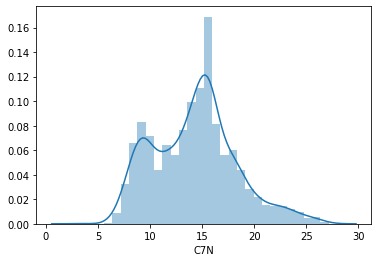

In [16]:
sns.distplot(full[y_name])